In [37]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import pandas as pd
import numpy as np
from helpers import (
    load_data,
    EMG_CHANNELS,
    EMG_HP_CHANNELS,
    GYRO_CHANNELS,
    ACC_CHANNELS,
    IMU_CHANNELS,
)
from feature_extraction import (
    FeatureExtractor,
    process_dataframe,
    zero_crossings,
    peak_frequency,
    mean_crossings
)
from sklearn.decomposition import KernelPCA
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
dataset = load_data()
dataset

Trimming observations to 967 samples


time_ms       ch0       ch1  ch0_hp  ch1_hp        qx  \
body_label rep                                                              
0          1    1514824.503  12535249  12566283  -11889   17295  0.321960   
           1    1514827.496  12536264  12559246   -2063   13384  0.321960   
           1    1514830.493  12538584  12565279    2757   16008  0.321960   
           1    1514833.500  12546745  12567024    7504    5644  0.321960   
           1    1514836.498  12537375  12545467   -3855  -15893  0.321960   
...                     ...       ...       ...     ...     ...       ...   
4          3    1618110.457  12136089  12370189  -31898   45780 -0.749451   
           3    1618113.448  12165574  12340495   20709    2953 -0.749451   
           3    1618116.437  12200077  12301532   45799  -36427 -0.725403   
           3    1618119.442  12153545  12317293  -14411   -3002 -0.725403   
           3    1618122.435  12099585  12324114  -50651   13979 -0.698059   

                      qy        qz        qw          gx          gy  \
body_label rep                                                         
0          1   -0.596619 -0.621826  0.392090   -1.342870    1.063105   
           1   -0.596741 -0.621826  0.392029   -1.510729    1.175011   
           1   -0.596741 -0.621765  0.391968   -1.230964    1.175011   
           1   -0.596741 -0.621765  0.391968   -1.230964    1.175011   
           1   -0.596802 -0.621765  0.391907   -1.063105    0.839294   
...                  ...       ...       ...         ...         ...   
4          3   -0.095520 -0.654175  0.034607 -167.187300 -729.625900   
           3   -0.095520 -0.654175  0.034607 -167.187300 -729.625900   
           3   -0.101318 -0.679504  0.041626 -168.474210 -807.568360   
           3   -0.101318 -0.679504  0.041626 -168.474210 -807.568360   
           3   -0.106567 -0.706360  0.049316 -169.984940 -887.133360   

                       gz         ax         ay        az  sample_num  
body_label rep                                                         
0          1     0.503576  -0.660156 -10.003906   1.21875         0.0  
           1     0.000000  -0.660156 -10.003906   1.21875         1.0  
           1    -0.279765  -0.660156 -10.003906   1.21875         2.0  
           1    -0.279765  -0.660156 -10.003906   1.21875         3.0  
           1    -0.727388  -0.660156 -10.003906   1.21875         4.0  
...                   ...        ...        ...       ...         ...  
4          3   -75.424520 -15.074219  -1.500000 -11.37500       962.0  
           3   -75.424520 -15.074219  -1.500000 -11.37500       963.0  
           3   -64.513700 -15.074219  -1.500000 -11.37500       964.0  
           3   -64.513700 -15.074219  -1.500000 -11.37500       965.0  
           3   -53.043358 -15.074219  -1.500000 -11.37500       966.0  

[14505 rows x 16 columns]

In [62]:
# Define feature extractors for each sensor

segment_length = 300
interval = 200

extractors = {}
extractors.update(
    {
        channel: [
            FeatureExtractor("mean", np.mean, segment_length=segment_length, interval=interval),
            FeatureExtractor("var", np.var, segment_length=segment_length, interval=interval),
            FeatureExtractor("mean_xing", mean_crossings),
            FeatureExtractor("min", np.min),
            FeatureExtractor("max", np.max),
        ]
        for channel in EMG_CHANNELS
    }
)


extractors.update(
    {
        channel: [
            FeatureExtractor("mean", np.mean, segment_length=segment_length, interval=interval),
            FeatureExtractor("var", np.var, segment_length=segment_length, interval=interval),
            FeatureExtractor("mean_xing", peak_frequency, segment_length=segment_length, interval=interval),
            FeatureExtractor("rmean", lambda x: np.mean(np.abs(x)))           

        ]
        for channel in EMG_HP_CHANNELS
    }
)

extractors.update(
    {
        channel: [
            FeatureExtractor("mean", np.mean, segment_length=segment_length, interval=interval),
            FeatureExtractor("var", np.var, segment_length=segment_length, interval=interval),
            FeatureExtractor("min", np.min),
            FeatureExtractor("max", np.max),
            FeatureExtractor("mean_xing", mean_crossings),
            FeatureExtractor("rmean", lambda x: np.mean(np.abs(x)))           

        ]
        for channel in IMU_CHANNELS
    }
)

extractors.update(
    {
        channel: [
            FeatureExtractor("mean", np.mean, segment_length=segment_length, interval=interval),
            FeatureExtractor("var", np.var, segment_length=segment_length, interval=interval),
            FeatureExtractor("mean_xing", mean_crossings),
            FeatureExtractor("rmean", lambda x: np.mean(np.abs(x)))           

      ]
        for channel in GYRO_CHANNELS
    }
)

extractors.update(
    {
        channel: [
            FeatureExtractor("mean", np.mean, segment_length=segment_length, interval=interval),
            FeatureExtractor("var", np.var, segment_length=segment_length, interval=interval),
            FeatureExtractor("min", np.min),
            FeatureExtractor("max", np.max),
            FeatureExtractor("mean_xing", mean_crossings),
            FeatureExtractor("rmean", lambda x: np.mean(np.abs(x)))           

        ]
        for channel in ACC_CHANNELS
    }
)

In [63]:
results = process_dataframe(dataset, extractors)
results

,ch0.mean.0.300,ch0.mean.200.500,ch0.mean.400.700,ch0.mean.600.900,ch0.var.0.300,ch0.var.200.500,ch0.var.400.700,ch0.var.600.900,ch0.mean_xing,ch0.min,...,az.mean.400.700,az.mean.600.900,az.var.0.300,az.var.200.500,az.var.400.700,az.var.600.900,az.min,az.max,az.mean_xing,az.rmean
0,0.802236,0.638268,0.236405,0.269670,-0.583682,-0.690240,-0.756767,-0.715512,0.241633,1.058481,...,-0.270765,0.033264,-0.984824,-0.951259,-0.652331,-0.553509,1.110080,-0.723182,-0.013094,-1.050832
1,-1.111186,0.673190,0.568211,0.901030,-0.054467,0.209050,-0.158889,-0.163269,-0.600185,0.035209,...,0.703717,0.630697,0.677069,-0.035297,-0.218018,-0.236874,0.758079,0.542911,-0.995114,0.247756
2,0.909974,-0.095089,-1.471562,-1.831561,-0.582047,0.127810,1.725635,1.729483,-0.857407,-1.582583,...,-1.477552,-1.510480,-1.050263,-0.646368,-0.332529,-0.111070,-1.310399,-1.013148,0.183311,-0.720752
3,1.058312,0.628681,-0.000771,-0.226596,-0.581083,-0.688467,-0.755152,-0.708372,1.784966,0.904112,...,-0.025651,-0.096195,-0.893930,-0.857912,-0.685301,-0.588150,1.015488,-0.678502,1.950948,-0.982443
4,0.390894,0.619202,0.107014,0.076032,-0.555173,-0.632793,-0.693095,-0.630707,-0.436498,0.862337,...,0.826454,1.298733,1.087180,0.483612,0.207115,0.133503,0.564709,0.677408,-0.995114,0.697622
5,-1.110074,-0.767111,-2.327882,-2.628022,1.413269,2.044058,2.555682,2.326417,-0.950943,-1.368386,...,-1.495579,-1.472785,0.161765,-0.467596,-0.352607,-0.159648,-1.155116,-0.762848,1.361735,-0.448847
6,0.759971,0.455385,-0.002108,-0.004502,-0.569740,-0.676004,-0.753832,-0.717485,0.943148,0.941675,...,-0.405691,-0.183750,-1.018477,-0.985822,-0.709401,-0.578024,0.987445,-1.088831,1.558139,-1.253161
7,0.173244,0.671922,0.150507,0.663593,-0.549489,-0.609401,-0.444460,-0.628266,-0.950943,0.490332,...,1.332525,0.658115,0.025463,-0.345006,-0.543623,-0.498790,0.863972,-0.016048,-0.798710,0.177918
8,-2.056773,-0.814277,1.584465,0.447103,2.563827,2.403388,0.677758,1.240101,-0.693720,-1.550883,...,-0.136687,-0.117735,1.359142,0.478664,-0.295258,-0.056857,-1.064709,-0.207991,-0.995114,0.189373
9,0.845345,0.144705,-0.336598,1.064602,-0.582861,-0.686727,-0.754363,-0.583000,0.966532,0.818850,...,-0.777713,-0.411336,-1.021083,-0.959578,-0.571764,-0.532995,0.573080,-0.990808,0.576119,-1.080754


<IPython.core.display.Javascript object>


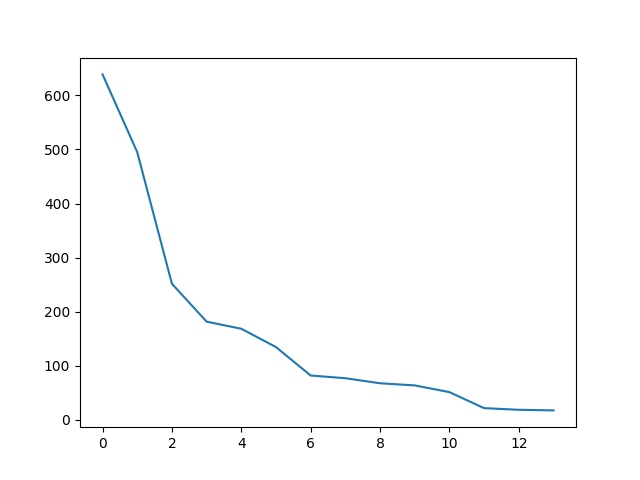

<IPython.core.display.Javascript object>


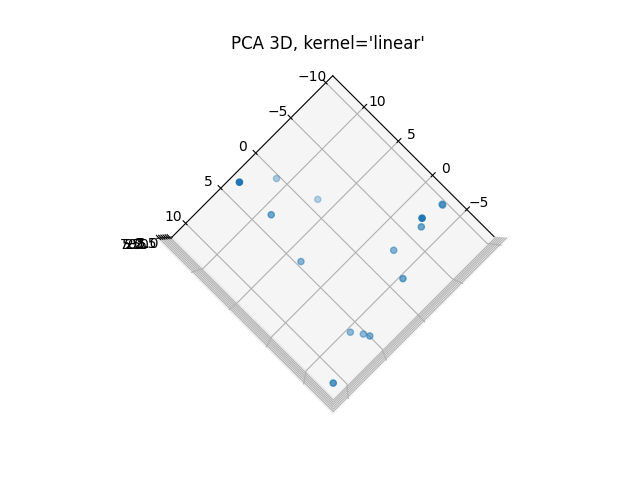

<IPython.core.display.Javascript object>


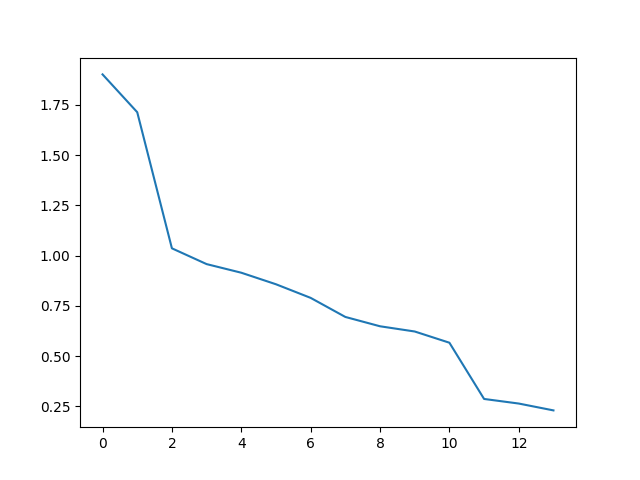

<IPython.core.display.Javascript object>


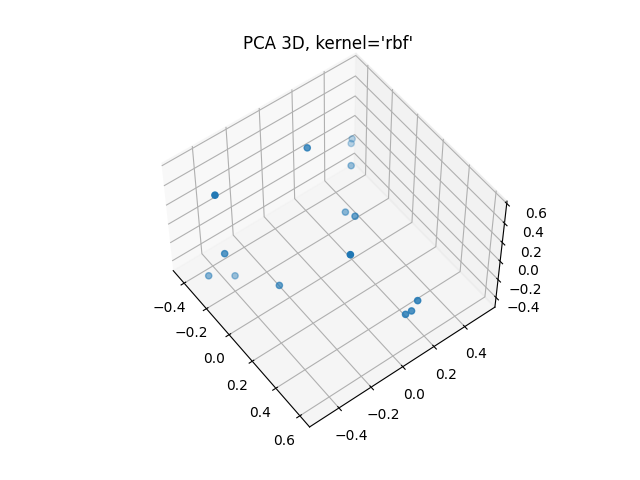

<IPython.core.display.Javascript object>


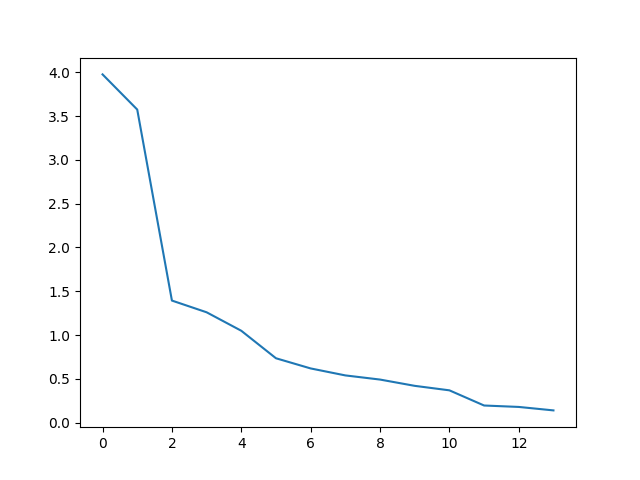

<IPython.core.display.Javascript object>


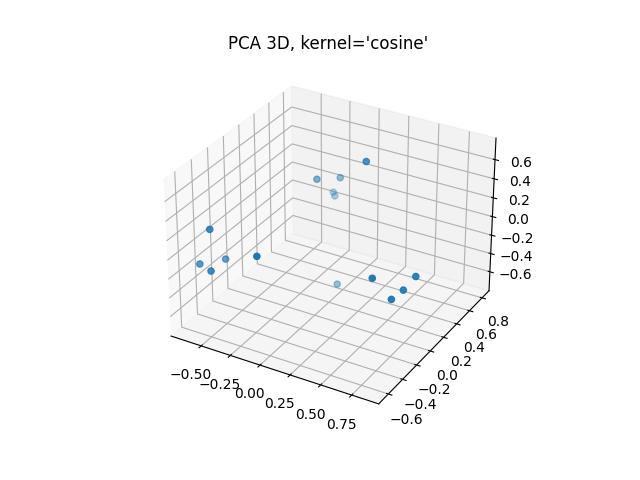

In [65]:
for kernel in ['linear', 'rbf', 'cosine']:
    pca = KernelPCA(kernel=kernel)
    pca.fit(results)
    output = pca.transform(results)
    fig = plt.figure()
    plt.plot(pca.eigenvalues_)
    plt.show()
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter(output[:, 0], output[:, 1], output[:, 2])
    plt.title(f'PCA 3D, {kernel=}')
    plt.show()
